In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn import metrics
#import eli5
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
from tqdm import tqdm
import train
from style import *
from sklearn import decomposition
import matplotlib.gridspec as grd

In [17]:
df = data_tracks.get_data()
n = df.shape[0]
bases = [f'sc_{i}' for i in range(12)] + [f'nmf_{i}' for i in range(12)]
patches = ['up_max', 'down_max', 'left_max', 'right_max']
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
              'rise', 'fall', 'X_std', 'X_min', 'X_mean', 'max_diff', 'min_diff'] + bases + patches

# loop over classifiers

In [ ]:
outcome_def = 'y_thresh'
out_dir = f'results/outcome={outcome_def}'
os.makedirs(out_dir, exist_ok=True)
for balancing in ['none']:
    for model_type in tqdm(['voting_mlp+svm+rf']): #,'gb', 'logistic', 'dt', 'svm', 'rf', 'mlp2', 'irf']):
        for num_feats in [4, 9, 11, 23, 35, 39]: #[23]:# [4, 6, 7, 9, 11]:
            feats = feat_names[:num_feats]
            out_name = f'{model_type}_{num_feats}_{balancing}'
            #print(out_name)
            train.train(df, feat_names=feats, model_type=model_type, balancing=balancing, outcome_def=outcome_def,
                        out_name=f'{out_dir}/{out_name}.pkl')

# classifier eda

In [ ]:
X = df[feat_names + ['y_thresh', 'y_single_sig']]
X = X.rename(columns={'mean_square_displacement': 'msd', 'total_displacement': 'td'})
X = (X - X.mean()) / X.std()

# make fig

# sns.clustermap(X.corr(method='spearman'), 
#                cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'), 
#                vmin=-1, vmax=1, figsize=(12, 12))
plt.figure(dpi=400, figsize=(12, 12))
sns.heatmap(X.corr(method='spearman'), 
            cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'), 
            vmin=-1, vmax=1
           )

plt.xticks(0.5 + np.arange(len(X.keys())), labels=X.keys())
plt.yticks(0.5 + np.arange(len(X.keys())), labels=X.keys())
# plt.savefig('results/heatmap.pdf')
plt.show()

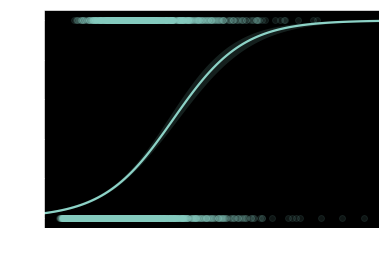

In [2]:
sns.regplot('X_max', 'y_thresh', df, scatter_kws={'alpha': 0.1}, logistic=True)
plt.hist(df['lifetime'][df['y_thresh']==0], alpha=0.5)
plt.hist(df['lifetime'][df['y_thresh']==1], alpha=0.5)
plt.show()

# dim reduction

In [19]:
# feats_to_reduce = feat_names[:11] 
feats_to_reduce = feat_names
X = df[feat_names]
X = (X - X.mean()) / X.std()
y = df['y_thresh'].values

**look at pcs**

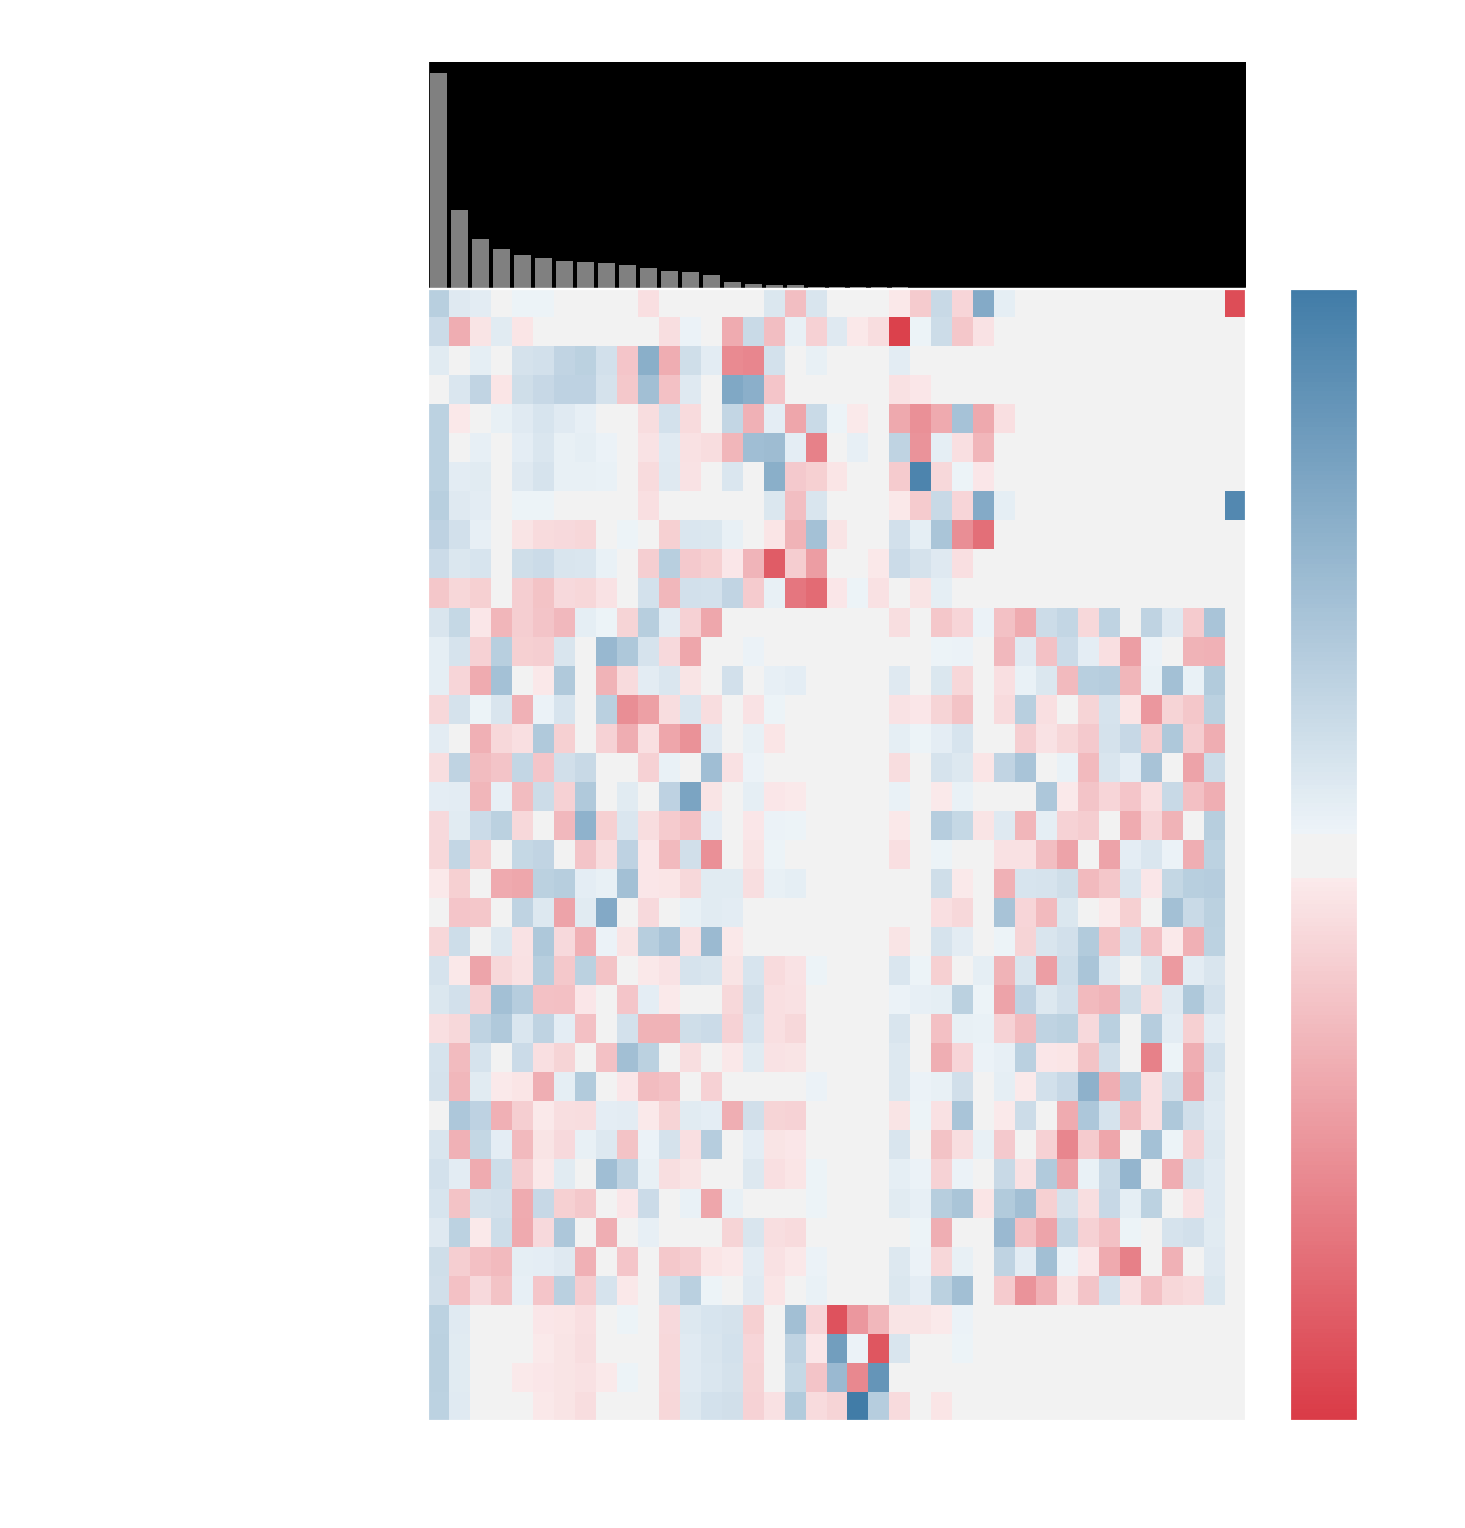

In [31]:
def plot_pcs(pca):
    '''Pretty plot of pcs with explained var bars
    Params
    ------
    pca: sklearn PCA class after being fitted
    '''
    # extract out relevant pars
    comps = pca.components_.transpose()
    var_norm = pca.explained_variance_ / np.sum(pca.explained_variance_) * 100
    
    
    # create a 2 X 2 grid 
    gs = grd.GridSpec(2, 2, height_ratios=[2,10], 
                      width_ratios=[12, 1], wspace=0.1, hspace=0)

    
    # plot explained variance
    ax2 = plt.subplot(gs[0])
    ax2.bar(np.arange(0, comps.shape[1]), var_norm, 
            color='gray', width=0.8)
    plt.title('Explained variance (%)')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.set_yticks([0, max(var_norm)])
    plt.xlim((-0.5, comps.shape[1]-0.5))
    
    # plot pcs
    ax = plt.subplot(gs[2])
    vmaxabs = np.max(np.abs(comps))
    p = ax.imshow(comps, interpolation='None', aspect='auto',
                  cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'),
                  vmin=-vmaxabs, vmax=vmaxabs) # center at 0
    plt.xlabel('PCA component number')
    ax.set_yticklabels(list(X))
    ax.set_yticks(range(len(list(X))))
    

    # make colorbar
    colorAx = plt.subplot(gs[3])
    cb = plt.colorbar(p, cax=colorAx)
    plt.show()
    

# perform pca
pca = decomposition.PCA(whiten=True)
# pca = decomposition.SparsePCA()
# pca = decomposition.NMF()
pca.fit(X)

plt.figure(figsize=(6, 9), dpi=200)
# plt.figure(figsize=(6, 5), dpi=200)
plot_pcs(pca)

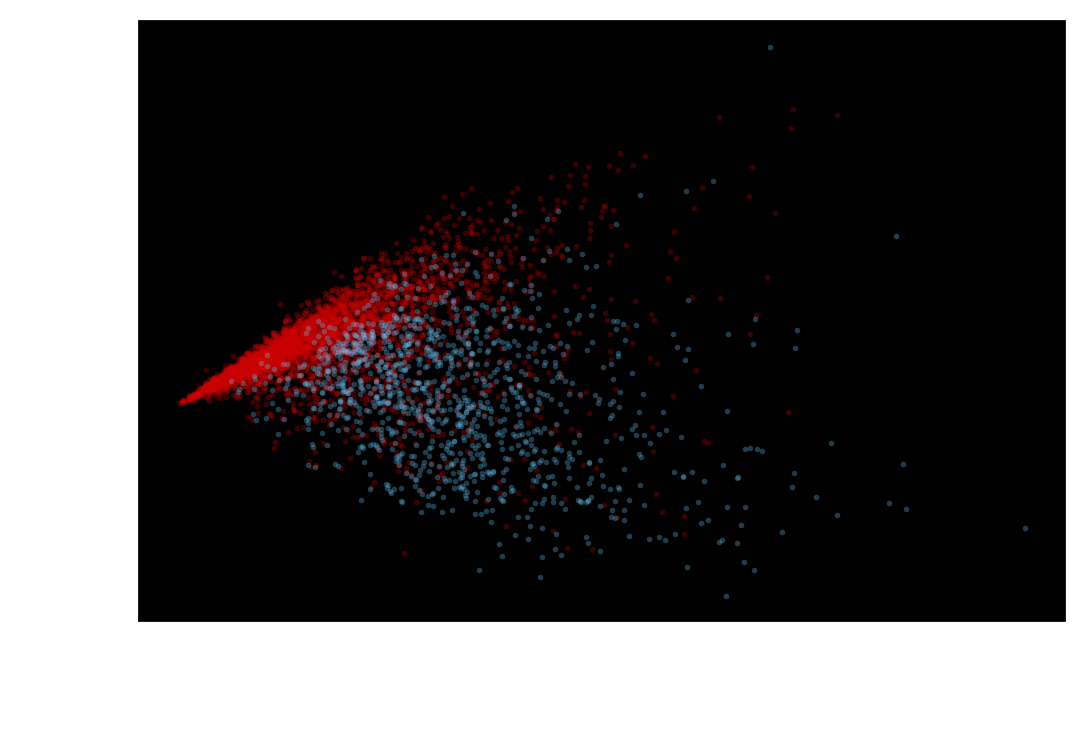

In [29]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)
plt.figure(dpi=200)
ys_neg = df['y_thresh'].values == 0
plt.plot(X_reduced[:, 0][ys_neg], X_reduced[:, 1][ys_neg], 'o', 
         color=cr, alpha=0.3, markeredgewidth=0, ms=2) #, c=df['y_thresh'].values, alpha=0.1)
plt.plot(X_reduced[:, 0][~ys_neg], X_reduced[:, 1][~ys_neg], 'o', 
         color=cb, alpha=0.3, markeredgewidth=0, ms=2)
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['y_thresh'].values, alpha=0.1, cmap={0:'red', 1:'blue'})
plt.xlabel('PC1')
plt.ylabel('PC2')
#             cdf[np.arange(X.shape[0]), cmap='viridis', alpha=0.1)
plt.show()